# Etheteum price prediction model

This project aims to predict the next-day price of Etheureum crypocurrency.

We will:

Start by using and understanding the model which Jose Pereira developed for Bitcoin, you can find it here https://github.com/pereirajose3/bitcoin_price_prediction_ensemble_bilstm-gru_savitzky_golay_filter/blob/main/ensemble_bilstm_gru_savitzky_golay_filter.ipynb. 

Once we understand the model, we will fine tune to Ethereum

If time allows, I would like to:

- Understand which variables help price prediction
- Predict at 1,2,3,4,5,6 months
- Tried and test other AI models

# 1. Import libraries

In [1]:
import os # Standart Library for programming, it lets me interact with several fuctions that come handy in day to day programming
import datetime # imports all the content from datatime module, which supplies classes to work with data and time

import IPython  # is a command sheel for interactive computing in multiple programing languages, which offers introspection, rich media, shell syntax, tab completion and history.
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras 
from tensorflow.keras import layers

In [2]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [3]:
#!pip install pydot
#pip install yfinance
#pip install yahoo_fin
#pip install requests_html

import yfinance as yf


In [4]:
from yahoo_fin.stock_info import get_data # import historical price data
import yahoo_fin.stock_info as si #Here we are just importing the whole stock_info module as si, so we can easily call all the methods without a new import each time.

2. Import Data

2.1 Download data from Yahoo:Finance API 

API is a set of defined rules that explain how computers or applications communicate with one another. It sits between an application and the web server,acting as an intermidiary layer that processes data transfer between systems.


In [5]:
# define start and end date of our data
start_date, end_date = '2017-11-09', '2023-02-01'

#Bitcoin USD
msft = yf.Ticker("BTC-USD")
# get historical market data
btc_usd = msft.history(interval='1d', start=start_date, end=end_date)
btc_usd.index = btc_usd.index.tz_localize(None)

#Ethereum USD (ETH-USD)
msft = yf.Ticker("ETH-USD")
# get historical market data
eth_usd = msft.history(interval='1d', start=start_date, end=end_date)
eth_usd.index = eth_usd.index.tz_localize(None)

#Nasdaq USD
msft = yf.Ticker("NDAQ")
# msft historical market data
nasdaq = msft.history(interval='1d', start=start_date, end=end_date)
nasdaq.index = nasdaq.index.tz_localize(None)


#Gold Prices
msft = yf.Ticker("GC=F")
# get historical market data
gold = msft.history(interval='1d', start=start_date, end=end_date)
gold.index = gold.index.tz_localize(None)

#Crude Oil
msft = yf.Ticker("CL=F")
# get historical market data
oil = msft.history(interval='1d', start=start_date, end=end_date)
oil.index = oil.index.tz_localize(None)

#SP500
msft = yf.Ticker("^GSPC")
# get historical market data
sp500 = msft.history(interval='1d', start=start_date, end=end_date)
sp500.index = sp500.index.tz_localize(None)

#VIX-Traders and investors use VIX as a measure of market sentiment and risk.
msft = yf.Ticker("^VIX")
# get historical market data
vix = msft.history(interval='1d', start=start_date, end=end_date)
vix.index = vix.index.tz_localize(None)

#ftse100
msft = yf.Ticker("^FTSE")
# get historical market data
ftse100 = msft.history(interval='1d', start=start_date, end=end_date)
ftse100.index = ftse100.index.tz_localize(None)

#TNX-is the ticker symbol for the 10-year Treasury note yield
msft = yf.Ticker("^TNX")
# get historical market data
tnx = msft.history(interval='1d', start=start_date, end=end_date)
tnx.index = tnx.index.tz_localize(None)

#CMC200: top  200 comapanies listed in Australia
msft = yf.Ticker("^CMC200")
# get historical market data
cmc200 = msft.history(interval='1d', start=start_date, end=end_date)
cmc200.index = cmc200.index.tz_localize(None)

#GBP/USD
msft = yf.Ticker("GBPUSD=X")
# get historical market data
gbp_usd = msft.history(interval='1d', start=start_date, end=end_date)
gbp_usd.index = gbp_usd.index.tz_localize(None)

#EUR/USD
msft = yf.Ticker("EURUSD=X")
# get historical market data
eur_usd = msft.history(interval='1d', start=start_date, end=end_date)
eur_usd.index = eur_usd.index.tz_localize(None)

#USD/JPY
msft = yf.Ticker("JPY=X")
# get historical market data
usd_jpy = msft.history(interval='1d', start=start_date, end=end_date)
usd_jpy.index = usd_jpy.index.tz_localize(None)


Import CPI data series from the BLS web service

In [6]:
import requests
import json

You need now to create an account to receive your private api key

In [7]:
bls_api_key = 'INSERT YOUR API PRIVATE KEY'

In [8]:
def fetch_cpi_data(data_series_id, start_year, end_year):
    try:
        bls_data_api_url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
        headers = {'Content-type': 'application/json'}
        data = json.dumps({"registrationkey": bls_api_key, "seriesid": [data_series_id], "startyear": start_year, "endyear": end_year})
        response = requests.post(bls_data_api_url, data=data, headers=headers)
        if response.status_code != 200:
            raise Exception(f"Error retrieving data: {response.text}")
        #  Parse JSON
        json_data = json.loads(response.text)
        if json_data['status'] != 'REQUEST_SUCCEEDED':
            raise Exception(f"Error retrieving data: {response.text}")
        results_df = pd.DataFrame()
        for series in json_data['Results']['series']:
            series_id = series['seriesID']
            for item in series['data']:
                year = int(item['year'])
                period = item['period']
                value = float(item['value'])
                year_mon = f"{year}-{int(period.replace('M',''))}"
                date = datetime.datetime.strptime(year_mon, "%Y-%m")
                row_df = pd.DataFrame({'date': [date], 'year': [year], 'period': [period], 'value': [value]})
                results_df = pd.concat([results_df, row_df], ignore_index=True)
        #  Sort ascending
        results_df = results_df.sort_values(by=['date'], ascending=True)
        results_df.set_index(['date'], inplace=True)
        return results_df
    except Exception as ex:
        print(f"Failed to fetch data: {ex}")

In [9]:
#  Set date range
today = datetime.date.today()
end_year_str = str(today.year)
days_delta = datetime.timedelta(5 * 365)
start_date = today - days_delta
start_year_str = str(start_date.year)
    
#  Fetch CPI
data_series_id = 'CUUR0000SA0'
cpi_data_df = fetch_cpi_data(data_series_id, start_year_str, end_year_str)
cpi_data_df.to_csv('cpi_data_df.csv')


In [10]:
# Calculate inflation rate
cpi_data_df['inflation_rate'] = cpi_data_df['value'].pct_change()*100
cpi_data_df['cpi_value'] = cpi_data_df['value']
# Display dataframe
print(cpi_data_df)

            year period    value  inflation_rate  cpi_value
date                                                       
2018-01-01  2018    M01  247.867             NaN    247.867
2018-02-01  2018    M02  248.991        0.453469    248.991
2018-03-01  2018    M03  249.554        0.226113    249.554
2018-04-01  2018    M04  250.546        0.397509    250.546
2018-05-01  2018    M05  251.588        0.415892    251.588
...          ...    ...      ...             ...        ...
2022-10-01  2022    M10  298.012        0.405649    298.012
2022-11-01  2022    M11  297.711       -0.101003    297.711
2022-12-01  2022    M12  296.797       -0.307009    296.797
2023-01-01  2023    M01  299.170        0.799536    299.170
2023-02-01  2023    M02  300.840        0.558211    300.840

[62 rows x 5 columns]


Create a data frame of all the data

In [11]:
#Create a dataframe with closing prices
btc_usd=btc_usd
eth_usd['eth_usd']=eth_usd['Close']
nasdaq['nasdaq']=nasdaq['Close']
gold['gold']=gold['Close']
oil['oil']=oil['Close']
sp500['sp500']=sp500['Close']
vix['vix']=vix['Close']
ftse100['ftse100']=ftse100['Close']
tnx['tnx']=tnx['Close']
cmc200['cmc200']=cmc200['Close']
gbp_usd['gbp_usd']=gbp_usd['Close']
eur_usd['eur_usd']=eur_usd['Close']
usd_jpy['usd_jpy']=usd_jpy['Close']
cpi_data_df['cpi_Data_df']=cpi_data_df['cpi_value']

df=pd.concat([eth_usd['Open'], eth_usd['High'], eth_usd['Low'], eth_usd['Close'], eth_usd['Volume'],nasdaq['nasdaq'], gold['gold'],oil['oil'],sp500['sp500'],vix['vix'],ftse100['ftse100'],tnx['tnx'],gbp_usd['gbp_usd'],eur_usd['eur_usd'],usd_jpy['usd_jpy'],cpi_data_df['cpi_value']], axis=1, join="outer")

In [12]:
eth_usd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1910 entries, 2017-11-09 to 2023-01-31
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1910 non-null   float64
 1   High          1910 non-null   float64
 2   Low           1910 non-null   float64
 3   Close         1910 non-null   float64
 4   Volume        1910 non-null   int64  
 5   Dividends     1910 non-null   float64
 6   Stock Splits  1910 non-null   float64
 7   eth_usd       1910 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 198.8 KB


In [13]:
df.count

<bound method DataFrame.count of                    Open         High          Low        Close        Volume  \
2017-11-09   308.644989   329.451996   307.056000   320.884003  8.932500e+08   
2017-11-10   320.670990   324.717987   294.541992   299.252991  8.859860e+08   
2017-11-11   298.585999   319.453003   298.191986   314.681000  8.423010e+08   
2017-11-12   314.690002   319.153015   298.513000   307.907990  1.613480e+09   
2017-11-13   307.024994   328.415009   307.024994   316.716003  1.041890e+09   
...                 ...          ...          ...          ...           ...   
2023-01-28  1598.125366  1604.704102  1565.390137  1572.435059  5.803653e+09   
2023-01-29  1572.629517  1653.724976  1568.984863  1646.155640  8.801292e+09   
2023-01-30  1646.147705  1646.651611  1546.660767  1567.326538  9.180418e+09   
2023-01-31  1567.419922  1598.517578  1563.804321  1586.535400  6.585191e+09   
2023-02-01          NaN          NaN          NaN          NaN           NaN   

      

In [14]:
df

,Open,High,Low,Close,Volume,nasdaq,gold,oil,sp500,vix,ftse100,tnx,gbp_usd,eur_usd,usd_jpy,cpi_value
2017-11-09,308.644989,329.451996,307.056000,320.884003,8.932500e+08,22.485588,1285.599976,57.169998,2584.620117,10.500000,7484.100098,2.331,1.311303,1.159689,113.927002,NaN
2017-11-10,320.670990,324.717987,294.541992,299.252991,8.859860e+08,22.436798,1272.400024,56.740002,2582.300049,11.290000,7433.000000,2.400,1.314440,1.164687,113.375000,NaN
2017-11-11,298.585999,319.453003,298.191986,314.681000,8.423010e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-12,314.690002,319.153015,298.513000,307.907990,1.613480e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-13,307.024994,328.415009,307.024994,316.716003,1.041890e+09,22.997946,1277.300049,56.759998,2584.840088,11.500000,7415.200195,2.400,1.312026,1.166113,113.685997,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-28,1598.125366,1604.704102,1565.390137,1572.435059,5.803653e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-29,1572.629517,1653.724976,1568.984863,1646.155640,8.801292e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-30,1646.147705,1646.651611,1546.660767,1567.326538,9.180418e+09,59.420177,1922.900024,77.900002,4017.770020,19.940001,7784.899902,3.551,1.240030,1.087146,129.854004,NaN
2023-01-31,1567.419922,1598.517578,1563.804321,1586.535400,6.585191e+09,59.958096,1929.500000,78.870003,4076.600098,19.400000,7771.700195,3.529,1.235361,1.085069,130.479004,NaN


Fill the weekeds on stock price with friday price 

In [15]:
#Fill weekends na stock price with friday price
df.fillna(method='ffill', inplace=True)
df=df[1:]

In [16]:
#Fill the rest of null of cpi with median 
df['cpi_value'] = df['cpi_value'].fillna(df['cpi_value'].median())

In [17]:
df

,Open,High,Low,Close,Volume,nasdaq,gold,oil,sp500,vix,ftse100,tnx,gbp_usd,eur_usd,usd_jpy,cpi_value
2017-11-10,320.670990,324.717987,294.541992,299.252991,8.859860e+08,22.436798,1272.400024,56.740002,2582.300049,11.290000,7433.000000,2.400,1.314440,1.164687,113.375000,259.101
2017-11-11,298.585999,319.453003,298.191986,314.681000,8.423010e+08,22.436798,1272.400024,56.740002,2582.300049,11.290000,7433.000000,2.400,1.314440,1.164687,113.375000,259.101
2017-11-12,314.690002,319.153015,298.513000,307.907990,1.613480e+09,22.436798,1272.400024,56.740002,2582.300049,11.290000,7433.000000,2.400,1.314440,1.164687,113.375000,259.101
2017-11-13,307.024994,328.415009,307.024994,316.716003,1.041890e+09,22.997946,1277.300049,56.759998,2584.840088,11.500000,7415.200195,2.400,1.312026,1.166113,113.685997,259.101
2017-11-14,316.763000,340.177002,316.763000,337.631012,1.069680e+09,23.168726,1281.500000,55.700001,2578.870117,11.590000,7414.399902,2.381,1.312336,1.166494,113.584999,259.101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-28,1598.125366,1604.704102,1565.390137,1572.435059,5.803653e+09,60.266903,1928.599976,79.680000,4070.560059,18.510000,7765.200195,3.518,1.241527,1.089443,129.800003,299.170
2023-01-29,1572.629517,1653.724976,1568.984863,1646.155640,8.801292e+09,60.266903,1928.599976,79.680000,4070.560059,18.510000,7765.200195,3.518,1.241527,1.089443,129.800003,299.170
2023-01-30,1646.147705,1646.651611,1546.660767,1567.326538,9.180418e+09,59.420177,1922.900024,77.900002,4017.770020,19.940001,7784.899902,3.551,1.240030,1.087146,129.854004,299.170
2023-01-31,1567.419922,1598.517578,1563.804321,1586.535400,6.585191e+09,59.958096,1929.500000,78.870003,4076.600098,19.400000,7771.700195,3.529,1.235361,1.085069,130.479004,299.170


In [18]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Volume       0
nasdaq       0
gold         0
oil          0
sp500        0
vix          0
ftse100      0
tnx          0
gbp_usd      0
eur_usd      0
usd_jpy      0
cpi_value    0
dtype: int64

In [19]:
cpi_data_df.head()

,year,period,value,inflation_rate,cpi_value,cpi_Data_df
date,,,,,,
2018-01-01,2018,M01,247.867,NaN,247.867,247.867
2018-02-01,2018,M02,248.991,0.453469,248.991,248.991
2018-03-01,2018,M03,249.554,0.226113,249.554,249.554
2018-04-01,2018,M04,250.546,0.397509,250.546,250.546
2018-05-01,2018,M05,251.588,0.415892,251.588,251.588


In [20]:
cpi_data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 2018-01-01 to 2023-02-01
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            62 non-null     int64  
 1   period          62 non-null     object 
 2   value           62 non-null     float64
 3   inflation_rate  61 non-null     float64
 4   cpi_value       62 non-null     float64
 5   cpi_Data_df     62 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 5.4+ KB


In [21]:
eth_usd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1910 entries, 2017-11-09 to 2023-01-31
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1910 non-null   float64
 1   High          1910 non-null   float64
 2   Low           1910 non-null   float64
 3   Close         1910 non-null   float64
 4   Volume        1910 non-null   int64  
 5   Dividends     1910 non-null   float64
 6   Stock Splits  1910 non-null   float64
 7   eth_usd       1910 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 198.8 KB


# 2.2 Features description

Close- Ethereum closing price in USD

Open- Ethereum opening price in USD

High- Ethereum highest price of the day in USD

Low- Ethereum lowest price of the day in USD

Volume- Ethereum total transactions volume of the day

Nasdak- National Association of Securities Dealers Automated Quotations closing price in USD

SP500- Standard and Poor's 500 closing price in USD. Index of 500 large listed limited liability companies traded in the United 
States

Gold- Gold closing price in USD

Oil- Oil closing price in USD

Vix- Volatility Index closing price in USD. Measure of stock market expectations of volatility based on S&P 500 index

Ftse100- Financial Times Stock Exchange 100 Index closing price in GBP. Share index of the 100 companies listed on the London 
Stock Exchange with the highest market capitalisation. 

Tnx- Treasury Yield 10 Years

Gbp_usd- British pound sterling closing price in USD

Eur_usd- Euro closing price in USD

Usd_jpy- US Dollar closing price in Japanese yen



2.3 Descriptive statistics

In [22]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [23]:
df.describe().transpose().rename(columns={'count': 'count', 'mean':'mean', 'std':'standard deviation', 'min':'minimum', '25%':'25% percentile', '50%':'median', '75%':'75% percentil', 'max':'maximum'})

,count,mean,standard deviation,minimum,25% percentile,median,75% percentil,maximum
Open,1910.000,1135.598,1179.653,84.280,212.040,534.579,1740.951,4810.071
High,1910.000,1171.847,1215.629,85.343,218.066,549.136,1794.736,4891.705
Low,1910.000,1094.605,1138.068,82.830,207.783,513.535,1677.543,4718.039
Close,1910.000,1136.035,1179.080,84.308,211.869,537.112,1741.246,4812.087
Volume,1910.000,12811143957.835,10728359941.270,621732992.000,4492992369.250,10442416221.000,18068212000.000,84482912776.000
nasdaq,1910.000,41.750,14.225,22.437,28.492,38.258,56.357,69.549
gold,1910.000,1602.121,250.203,1176.200,1321.125,1700.500,1812.525,2051.500
oil,1910.000,64.769,19.633,-37.630,53.780,63.010,74.050,123.700
sp500,1910.000,3435.478,671.157,2237.400,2826.060,3265.350,4017.808,4796.560
vix,1910.000,20.871,8.338,9.150,15.263,19.400,24.720,82.690


Text(0.5, 1.0, 'Inflation in the USA by month Base year: 1982-84=100')

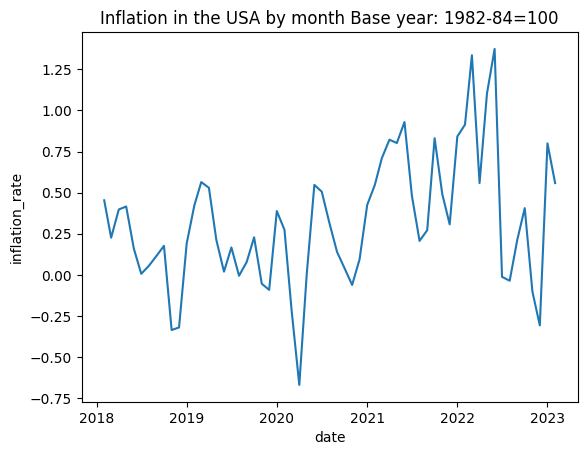

In [24]:
sns.lineplot(x="date", y="inflation_rate",
             data=cpi_data_df)
# Add title
plt.title("Inflation in the USA by month Base year: 1982-84=100")

Text(0.5, 1.0, 'Consumer Price Index in the USA, Base year: 1982-84=100')

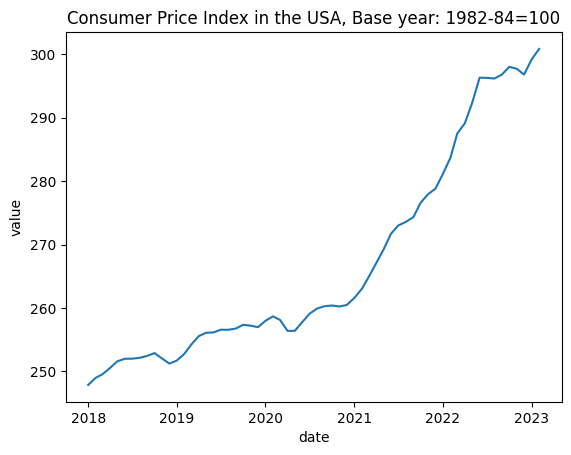

In [25]:
sns.lineplot(x="date", y="value",
             data=cpi_data_df)
# Add title
plt.title("Consumer Price Index in the USA, Base year: 1982-84=100")

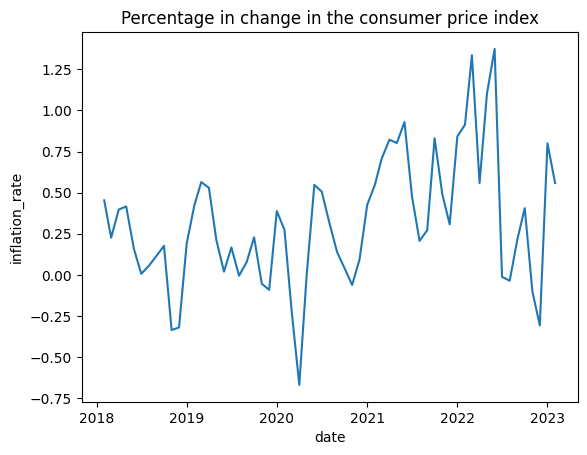

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate inflation rate as a percentage
cpi_data_df['inflation_rate'] = cpi_data_df['value'].pct_change() * 100

# Create line plot
sns.lineplot(x="date", y="inflation_rate", data=cpi_data_df)

# Add title
plt.title("Percentage in change in the consumer price index")

# Show plot
plt.show()


## 3 - Data smoothing with Savitzky–Golay filter

This is a digital filter which helps smooth the data to increase precision without distorting the signal tendency

In [27]:
# Smooth the target variable Ethereum closing price
from scipy.signal import savgol_filter

In [28]:
# Savitzky-Golay filter
df['savgol'] = savgol_filter(df['Close'], 29, 9)


In [29]:
df_plot = pd.DataFrame({'Savitzky–Golay':df['savgol'], 'eth_usd': df['Close']})
import plotly.express as px
fig = px.line(df_plot, x=df_plot.index.values, y=df_plot.columns,
              title='custom tick labels')
fig.update_layout(title_text='Actual vs Prediction', 
                   font_size=15, font_color='black', legend_title_text='Legend')
fig.update_xaxes(title='Days')
fig.update_yaxes(title='Ethereum closing price in USD')
fig.show()

4. Feature selection

In [30]:
# Select ethereum closing price and ethereum closing price smoothed with Savitzky–Golay filter

In [31]:
#df=df[['Close','savgol']]

5. Splinting the dataset into train, validation and test.

Validation is used for fine tuning

In [32]:
# Split train data, validation and test data
# when working with time series data, it is important, to use validation and test data that is more recent that the train data, because you are
#trying to predict the future given the past, not the reverse, and your validation/test splits should reflect
train_size = int(len(df)*0.60)
validation_size = int(len(df)*0.20)
train_dataset, validation_dataset, test_dataset = df.iloc[:train_size],df.iloc[train_size:train_size+validation_size], df.iloc[train_size+validation_size:]

Dimension of train data:  (1146, 17)
Dimension of test data:  (382, 17)
Dimension of test data:  (382, 17)


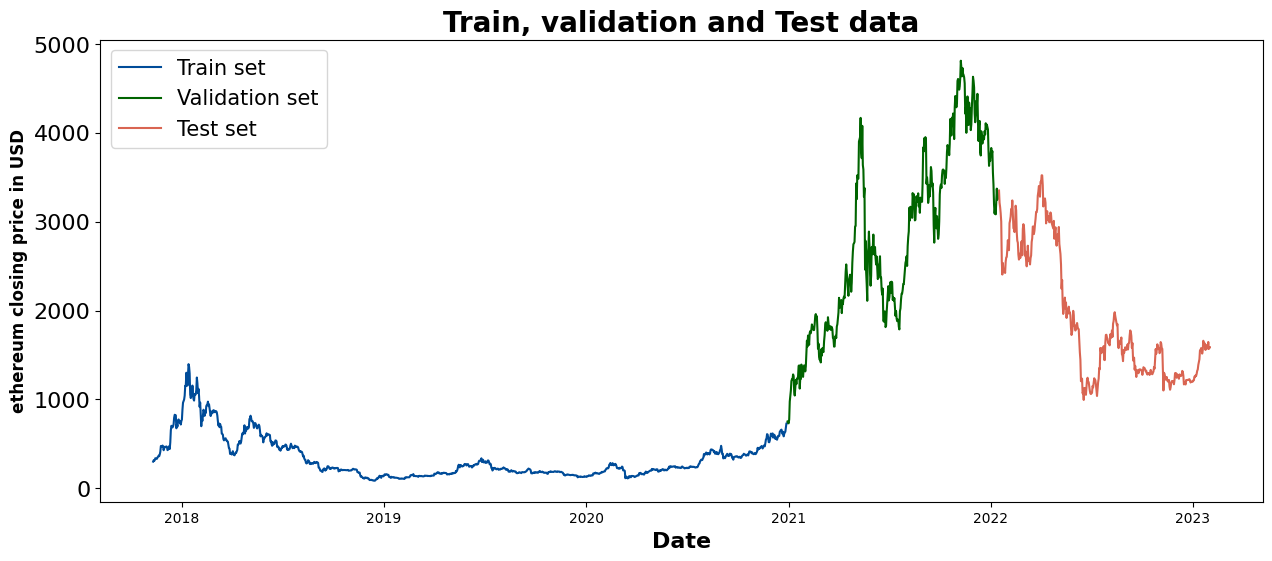

In [33]:
fig, ax = plt.subplots(figsize = (15,6))
ax.plot(train_dataset.Close,color="#004C99")
ax.plot(validation_dataset.Close,color='darkgreen')
ax.plot(test_dataset.Close,color="#D96552")
# Formatting
ax.set_title('Train, validation and Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('ethereum closing price in USD', fontsize = 12, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.grid(b=False,axis = 'y')
ax.grid(b=False,axis = 'y')
plt.legend(['Train set','Validation set', 'Test set'], loc='upper left',prop={'size': 15})
print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', validation_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

6. Data pre-processing

6.1 Seperating the target and dependent variables.

In [34]:
# Split train data to X and y
X_train = train_dataset.loc[:,['Close','oil']]
y_train = train_dataset.loc[:,['savgol']]
y_train_copy = train_dataset.loc[:,['Close']]

# Split train data to X and y
X_validation = validation_dataset.loc[:,['Close','oil']]
y_validation = validation_dataset.loc[:,['Close']]
y_validation_copy = validation_dataset.loc[:,['Close']]

# Split test data to X and y
X_test = test_dataset.loc[:,['Close','oil']]
y_test = test_dataset.loc[:,['Close']]
y_test_copy=test_dataset.loc[:,['Close']]

In [35]:
print("X_train Dimensions:", X_train.shape)
print("y_train Dimensions:", y_train.shape)
print("X_validation Dimensions:", X_validation.shape)
print("y_validation Dimensions:", y_validation.shape)
print("X_test Dimensions:", X_test.shape)
print("y_test Dimensions:", y_test.shape)

X_train Dimensions: (1146, 2)
y_train Dimensions: (1146, 1)
X_validation Dimensions: (382, 2)
y_validation Dimensions: (382, 1)
X_test Dimensions: (382, 2)
y_test Dimensions: (382, 1)


6.2 Feature scaling- normalization Min-Max

In [36]:
# MinMaxScaler is used to normalize the data
scaler = MinMaxScaler()

# Apply the scaler to training data
X_train = scaler.fit_transform(X_train)
y_train = scaler.fit_transform(y_train)

# Apply the scaler to validation data
X_validation = scaler.fit_transform(X_validation)
y_validation = scaler.fit_transform(y_validation)

# Apply the scaler to test data
X_test = scaler.fit_transform(X_test)
y_test = scaler.fit_transform(y_test)

6.3 Data representation neural networks - rank- 3 tensor

In [37]:
# Create a 3D input 
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)
TIME_STEPS = 16
X_test, y_test = create_dataset(X_test, y_test, TIME_STEPS)
X_val, y_val = create_dataset(X_validation, y_validation, TIME_STEPS)
X_train, y_train = create_dataset(X_train, y_train,TIME_STEPS)

print("X_train Dimensions:", X_train.shape)
print("y_train Dimensions:", y_train.shape)
print("X_val Dimensions:", X_val.shape)
print("y_val Dimensions:", y_val.shape)
print("X_test Dimensions:", X_test.shape)
print("y_test Dimensions:", y_test.shape)

X_train Dimensions: (1130, 16, 2)
y_train Dimensions: (1130, 1)
X_val Dimensions: (366, 16, 2)
y_val Dimensions: (366, 1)
X_test Dimensions: (366, 16, 2)
y_test Dimensions: (366, 1)


7. Baseline Performance 

7.1 Moving average -20 days

This applies the most simple model ( traditional/ manual way) of forecasting to have the baseline of our errors. if the deep models generate better error metrics, it means they surpass the simple forecasting model, otherwise there is no point of builing a prediction model that is more complex.

In [38]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
# Error metrics Computation

original_ytest1 = scaler.inverse_transform(y_test)
ma_20=df['Close'].rolling(20).mean().to_numpy()[(df.shape[0]-y_test.shape[0]):]

print("MAE : % f" %(mean_absolute_error(original_ytest1, ma_20)))
print("RMSE : % f" %(mean_squared_error(original_ytest1, ma_20, squared=False)))
print("MAPE : % f" %(mean_absolute_percentage_error(original_ytest1, ma_20)*100))
print("R2 : % f" %(r2_score(original_ytest1, ma_20)))

MAE :  165.700682
RMSE :  214.278946
MAPE :  9.364503
R2 :  0.906519


MAPE : mean absolute percentage error. It's the sum of the individual absolute erros divided by the demand ( each period seperatly). It is the average of the percentage errors, so its skewed. Most likely undeshoots demand- avoid in forecasting.

MAE: Mean absolute error, good measure for forecast accuracy. Not scale to the average demand.

Root mean squared error (RMSE): square root of the average square error- we dont need to use it to evaluate statistical forecast mdoels.

RMSE emphasizes the most significant errors, whereas MAE gives the same importance to each error.




8. Deep learnig models

In [39]:
# # Model building and training
import keras
from keras.layers import Input, LSTM, GRU, Activation, Dense
from keras.models import Sequential, Model
from keras.callbacks import LearningRateScheduler

In [40]:
from tensorflow import keras 
from tensorflow.keras import layers

8.1 LSTM Model

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from keras.layers import LeakyReLU

# Initialising the LSTM
model_simple_lSTM = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model_simple_lSTM.add(LSTM(units = 128, activation='sigmoid', input_shape = (X_train.shape[1], X_train.shape[2])))
model_simple_lSTM.add(Dropout(0.6))

# Adding the output layer
model_simple_lSTM.add(Dense(units = 1))

# Compiling the RNN
model_simple_lSTM.compile(optimizer = 'Adam', metrics=["mae"], loss = 'mean_squared_error')

In [42]:
tf.keras.utils.plot_model(
    model_simple_lSTM,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [43]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


#early_stop and ModelCheckpoint
# the model stops learning when 
callbacks  = [keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 30, mode='min', min_delta=0),
              keras.callbacks.ModelCheckpoint("model_simple_lSTM.keras", monitor='val_loss', save_best_only=True, mode='min')]

In [44]:
history_simple_lSTM = model_simple_lSTM.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), batch_size=32, 
                             callbacks = [callbacks])

Epoch 1/200
36/36 [==============================] - 2s 15ms/step - loss: 0.2843 - mae: 0.4223 - val_loss: 0.0954 - val_mae: 0.2444
Epoch 2/200
36/36 [==============================] - 0s 10ms/step - loss: 0.1524 - mae: 0.3095 - val_loss: 0.1381 - val_mae: 0.3081
Epoch 3/200
36/36 [==============================] - 0s 10ms/step - loss: 0.1049 - mae: 0.2632 - val_loss: 0.1256 - val_mae: 0.2912
Epoch 4/200
36/36 [==============================] - 0s 10ms/step - loss: 0.0782 - mae: 0.2202 - val_loss: 0.1346 - val_mae: 0.3056
Epoch 5/200
36/36 [==============================] - 0s 10ms/step - loss: 0.0708 - mae: 0.2068 - val_loss: 0.1082 - val_mae: 0.2659
Epoch 6/200
36/36 [==============================] - 0s 10ms/step - loss: 0.0620 - mae: 0.1956 - val_loss: 0.1095 - val_mae: 0.2684
Epoch 7/200
36/36 [==============================] - 0s 10ms/step - loss: 0.0515 - mae: 0.1773 - val_loss: 0.1149 - val_mae: 0.2767
Epoch 8/200
36/36 [==============================] - 0s 10ms/step - loss: 0.

In [45]:
model_simple_lSTM = keras.models.load_model("model_simple_lSTM.keras")

Train/ Validation loss plot for long short-term memory

Then we go into the validation dataset. The validation helps us do the fine tunning of the data.

In [46]:
# Plot train loss and validation loss
def plot_loss (history):
    fig, ax = plt.subplots(figsize = (15,6))
    ax.plot(history.history['loss'],color="#004C99")
    ax.plot(history.history['val_loss'],color="#D96552")
    #ax.set_facecolor("#D3D3D3")
    plt.grid(b=False,axis = 'y')
    ax.grid(b=False,axis = 'y')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right',prop={'size': 15})

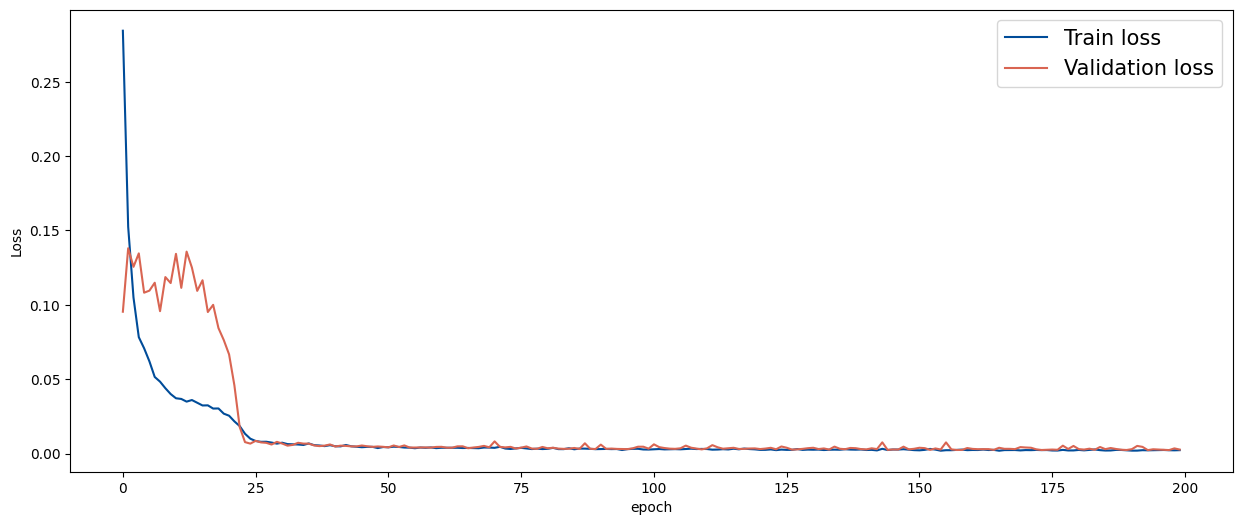

In [47]:
plot_loss (history_simple_lSTM)

LSTM Model validation

###  Inverse and transform the target variable
Save in a new variable, because we need y_val and y_val to train more models.

In [48]:
original_yval = scaler.inverse_transform(y_val)

LSTM Model predictions

In [49]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_val)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_simple_lSTM= prediction(model_simple_lSTM)

12/12 [==============================] - 0s 3ms/step


Actual vs prediction plot function

In [50]:
# Plot true future vs prediction
def plot_future(prediction, y_test):
    fig, ax = plt.subplots(figsize = (15,8))
    range_future = len(prediction)
    ax.set_title('Actual vs Prediction', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
    ax.set_xlabel('Day', fontsize = 16, fontdict=dict(weight='bold'))
    ax.set_ylabel('Bitcoin closing price in USD', fontsize = 14, fontdict=dict(weight='bold'))
    ax.plot(np.array(y_test),label='Actual',color="#004C99")
    ax.plot(np.array(prediction),label='Prediction',color="#D96552")
    #ax.set_facecolor("#D3D3D3")
    plt.xticks(np.arange(0,len(prediction),50),fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.grid(b=False,axis = 'y')
    ax.grid(b=False,axis = 'y')
    plt.legend(loc='upper left',prop={'size': 15})
    #plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False) 
    plt.show() 

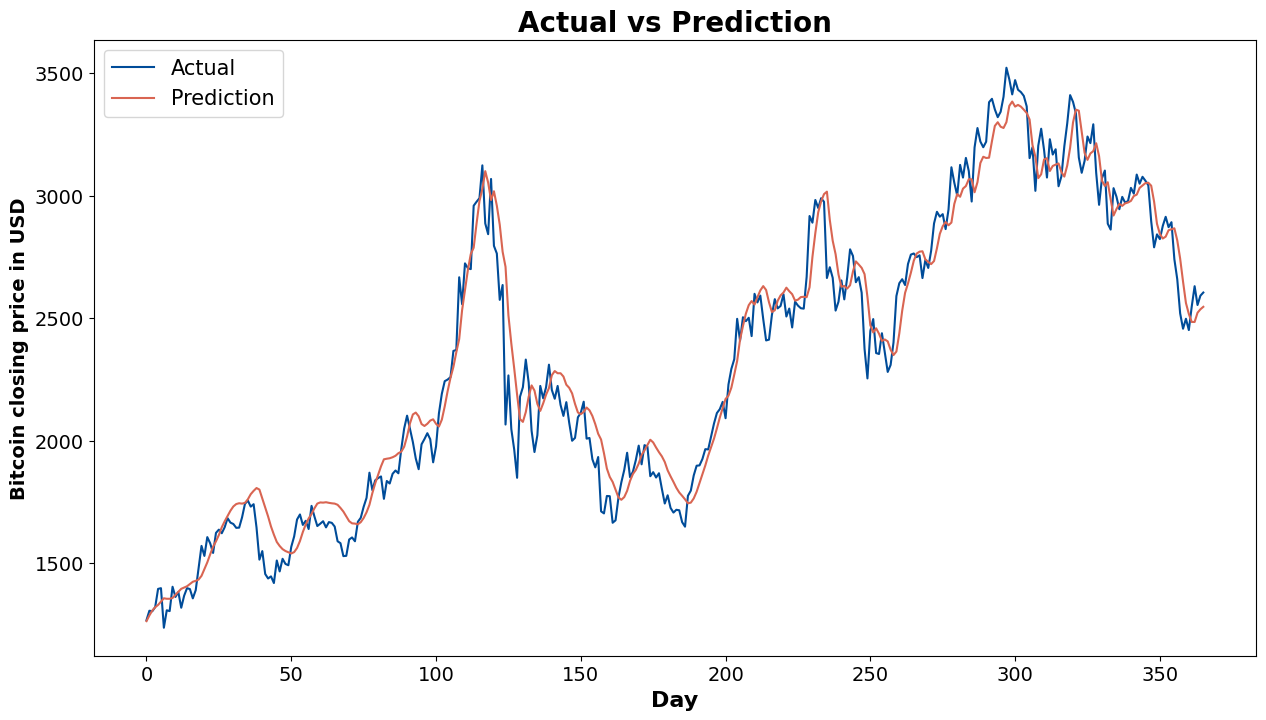

In [51]:
plot_future(prediction_simple_lSTM, original_yval)

In [52]:
df_plot = pd.DataFrame({ 'Actual': original_yval.squeeze(), 'Prediction':prediction_simple_lSTM.squeeze() })
import plotly.express as px
fig = px.line(df_plot, x=df_plot.index.values, y=df_plot.columns,
              title='custom tick labels')
fig.update_layout(title_text='Actual vs Prediction', 
                   font_size=15, font_color='black', legend_title_text='Legend')
fig.update_xaxes(title='Days')
fig.update_yaxes(title='Bitcoin closing price in USD')
fig.show()

Evaluating the LSTM model in validation data

In [53]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
# Error metrics Computation
print('Simple LSTM:')
print("MAE : % f" %(mean_absolute_error(original_yval, prediction_simple_lSTM)))
print("RMSE : % f" %(mean_squared_error(original_yval, prediction_simple_lSTM, squared=False)))
print("MAPE : % f" %(mean_absolute_percentage_error(original_yval, prediction_simple_lSTM)*100))
print("R2 : % f" %(r2_score(original_yval, prediction_simple_lSTM)))

Simple LSTM:
MAE :  92.639149
RMSE :  121.045849
MAPE :  4.242229
R2 :  0.959538


# Test the LSTM Model

Inverse and transform the target varibale 

Save in a new variable, because we need y_test and y_train to train more models.

In [54]:
original_ytest = scaler.inverse_transform(y_test)

LSTM Model Predictions

In [55]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_simple_lSTM= prediction(model_simple_lSTM)

12/12 [==============================] - 0s 3ms/step


Actual vs prediction plot function

In [56]:
# Plot true future vs prediction
def plot_future(prediction, y_test):
    fig, ax = plt.subplots(figsize = (15,8))
    range_future = len(prediction)
    ax.set_title('Actual vs Prediction', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
    ax.set_xlabel('Day', fontsize = 16, fontdict=dict(weight='bold'))
    ax.set_ylabel('Ethereum closing price in USD', fontsize = 14, fontdict=dict(weight='bold'))
    ax.plot(np.array(y_test),label='Actual',color="#004C99")
    ax.plot(np.array(prediction),label='Prediction',color="#D96552")
    #ax.set_facecolor("#D3D3D3")
    plt.xticks(np.arange(0,len(prediction),50),fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.grid(b=False,axis = 'y')
    ax.grid(b=False,axis = 'y')
    plt.legend(loc='upper left',prop={'size': 15})
    #plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False) 
    plt.show() 

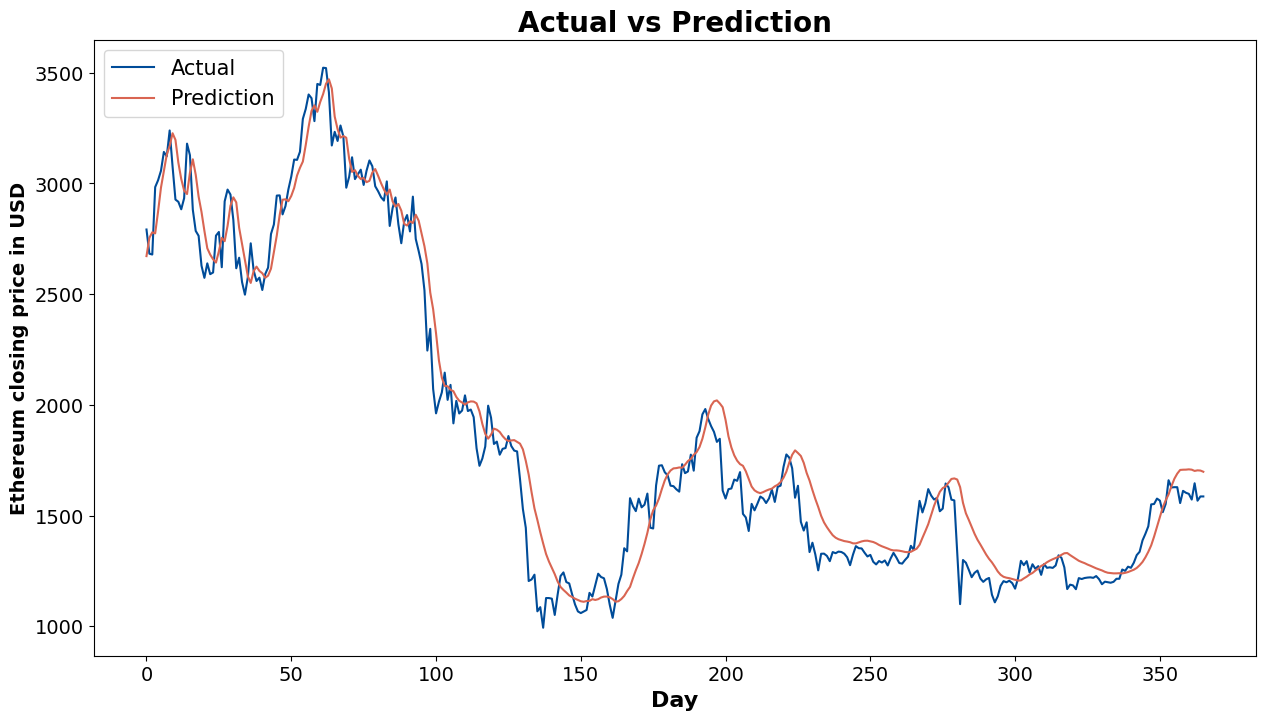

In [57]:
plot_future(prediction_simple_lSTM, original_ytest)

In [58]:
df_plot = pd.DataFrame({'Actual': original_ytest.squeeze(),'Prediction':prediction_simple_lSTM.squeeze() })
import plotly.express as px
fig = px.line(df_plot, x=df_plot.index.values, y=df_plot.columns,
              title='custom tick labels')
fig.update_layout(title_text='Actual vs Prediction', 
                   font_size=15, font_color='black', legend_title_text='Legend')
fig.update_xaxes(title='Days')
fig.update_yaxes(title='Ethereum closing price in USD')
fig.show()

Evaluating the LSTM model

In [59]:
# Error metrics Computation
print('Simple LSTM:')
print("MAE : % f" %(mean_absolute_error(original_ytest, prediction_simple_lSTM)))
print("RMSE : % f" %(mean_squared_error(original_ytest, prediction_simple_lSTM, squared=False)))
print("MAPE : % f" %(mean_absolute_percentage_error(original_ytest, prediction_simple_lSTM)*100))
print("R2 : % f" %(r2_score(original_ytest, prediction_simple_lSTM)))

Simple LSTM:
MAE :  105.255500
RMSE :  138.654943
MAPE :  6.435042
R2 :  0.960859


In [60]:
tf.keras.backend.clear_session()

8.2 BiLSTM model

In [61]:
from keras.layers import concatenate
from keras.layers import Bidirectional
input = Input((X_train.shape[1], X_train.shape[2]))
X = layers.Bidirectional(layers.LSTM(128, activation='sigmoid'))(input)
X = layers.Dropout(0.6)(X)
X = Dense(1)(X)
model_bilstm = Model(input, X)
model_bilstm.compile(loss='mse', metrics=["mae"], optimizer='adam')

In [62]:
tf.keras.utils.plot_model(
    model_bilstm,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [63]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


#early_stop and ModelCheckpoint
callbacks  = [keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, mode='min', min_delta=0),
              keras.callbacks.ModelCheckpoint("BILSTM.keras", monitor='val_loss', save_best_only=True, mode='min')]

In [64]:
history_bilstm = model_bilstm.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), batch_size=32,
                             callbacks = [callbacks])

Epoch 1/200
36/36 [==============================] - 2s 23ms/step - loss: 0.3480 - mae: 0.4657 - val_loss: 0.1200 - val_mae: 0.2783
Epoch 2/200
36/36 [==============================] - 1s 17ms/step - loss: 0.2066 - mae: 0.3652 - val_loss: 0.1100 - val_mae: 0.2665
Epoch 3/200
36/36 [==============================] - 1s 16ms/step - loss: 0.1433 - mae: 0.3013 - val_loss: 0.1281 - val_mae: 0.2965
Epoch 4/200
36/36 [==============================] - 1s 17ms/step - loss: 0.1062 - mae: 0.2596 - val_loss: 0.0967 - val_mae: 0.2489
Epoch 5/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0805 - mae: 0.2256 - val_loss: 0.1329 - val_mae: 0.3069
Epoch 6/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0754 - mae: 0.2133 - val_loss: 0.1407 - val_mae: 0.3196
Epoch 7/200
36/36 [==============================] - 1s 17ms/step - loss: 0.0596 - mae: 0.1930 - val_loss: 0.1161 - val_mae: 0.2820
Epoch 8/200
36/36 [==============================] - 1s 17ms/step - loss: 0.

In [65]:
model_bilstm = keras.models.load_model("BILSTM.keras")

Train- validation loss plot BiLSTM

In [66]:
# Plot train loss and validation loss
def plot_loss (history):
    fig, ax = plt.subplots(figsize = (15,6))
    ax.plot(history.history['loss'],color="#004C99")
    ax.plot(history.history['val_loss'],color="#D96552")
    #ax.set_facecolor("#D3D3D3")
    plt.grid(b=False,axis = 'y')
    ax.grid(b=False,axis = 'y')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right',prop={'size': 15})

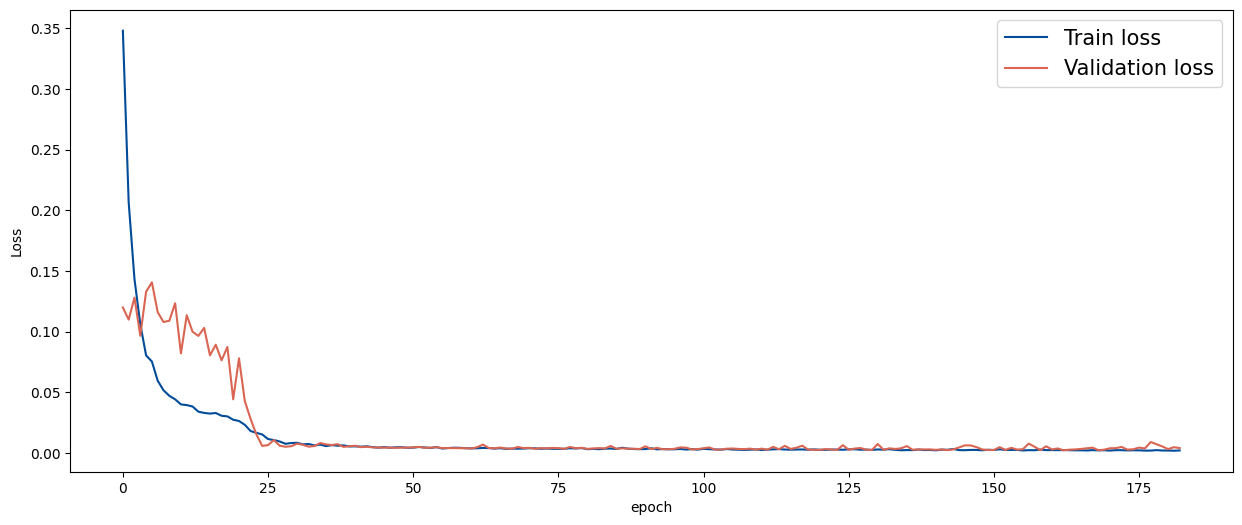

In [67]:
plot_loss (history_bilstm)

BiLSTM model validation

Inverse and transform the target variable

save in a new variable, because we need y_val and y_val to train more models.

In [68]:
original_yval = scaler.inverse_transform(y_val)

BiLSTM Model predictions

In [69]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_val)
    prediction = scaler.inverse_transform(prediction)
    return prediction



prediction_model_bilstm= prediction(model_bilstm)

12/12 [==============================] - 0s 3ms/step


Actual vs Prediction plot function

In [70]:
# Plot true future vs prediction
def plot_future(prediction, y_test):
    fig, ax = plt.subplots(figsize = (15,8))
    range_future = len(prediction)
    ax.set_title('Actual vs Prediction', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
    ax.set_xlabel('Day', fontsize = 16, fontdict=dict(weight='bold'))
    ax.set_ylabel('Ethereum closing price in USD', fontsize = 14, fontdict=dict(weight='bold'))
    ax.plot(np.array(y_test),label='Actual',color="#004C99")
    ax.plot(np.array(prediction),label='Prediction',color="#D96552")
    #ax.set_facecolor("#D3D3D3")
    plt.xticks(np.arange(0,len(prediction),50),fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.grid(b=False,axis = 'y')
    ax.grid(b=False,axis = 'y')
    plt.legend(loc='upper left',prop={'size': 15})
    #plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False) 
    plt.show() 

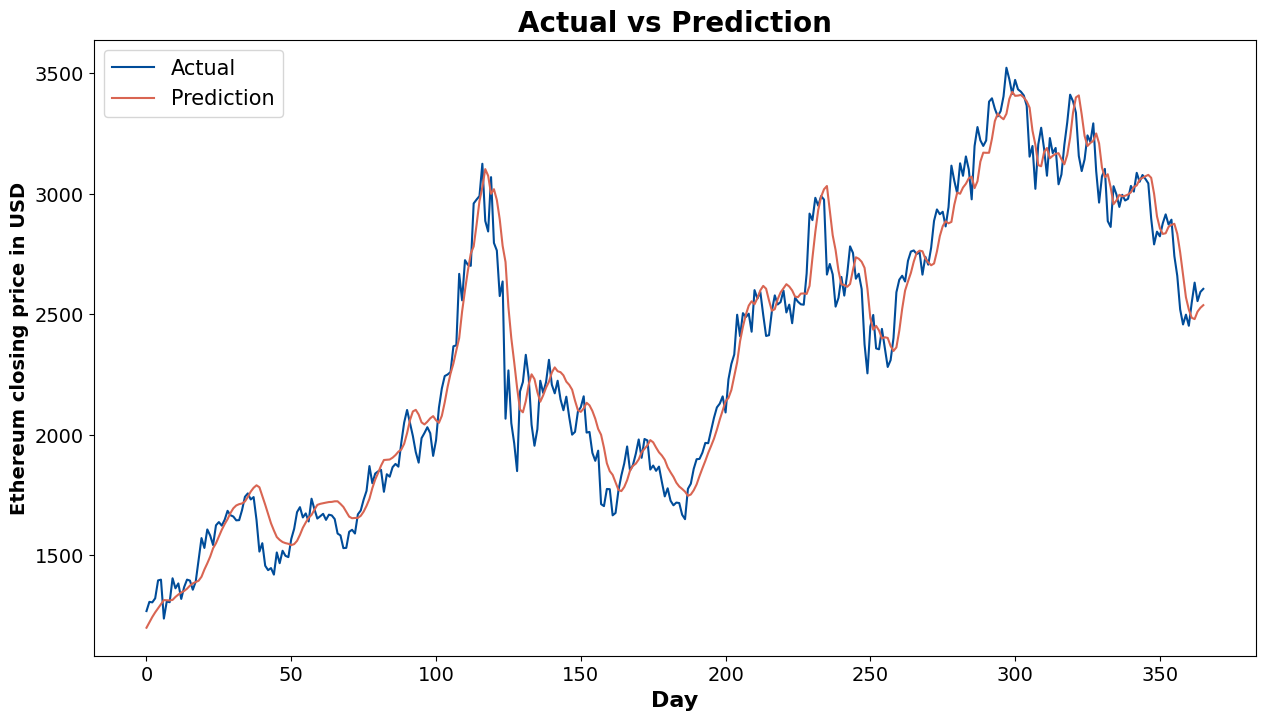

In [71]:
plot_future(prediction_model_bilstm, original_yval)

In [72]:
df_plot = pd.DataFrame({ 'Actual': original_yval.squeeze(), 'Prediction':prediction_model_bilstm.squeeze() })
import plotly.express as px
fig = px.line(df_plot, x=df_plot.index.values, y=df_plot.columns,
              title='custom tick labels')
fig.update_layout(title_text='Actual vs Prediction', 
                   font_size=15, font_color='black', legend_title_text='Legend')
fig.update_xaxes(title='Days')
fig.update_yaxes(title='Ethereum closing price in USD')
fig.show()

Evaluating the model in validation data

In [73]:
print('Simple LSTM:')
print("MAE : % f" %(mean_absolute_error(original_yval, prediction_model_bilstm)))
print("RMSE : % f" %(mean_squared_error(original_yval, prediction_model_bilstm, squared=False)))
print("MAPE : % f" %(mean_absolute_percentage_error(original_yval, prediction_model_bilstm)*100))
print("R2 : % f" %(r2_score(original_yval, prediction_model_bilstm)))

Simple LSTM:
MAE :  92.038515
RMSE :  121.849191
MAPE :  4.210168
R2 :  0.958999


# Test the model 

Inverse and transform the target varaiable

Save in a new variable, because we need y_test and y_tran to train more models

In [74]:
original_ytest = scaler.inverse_transform(y_test)

BILSTM model predictions

In [75]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction



prediction_bilstm = prediction(model_bilstm)

12/12 [==============================] - 0s 3ms/step


Actual vs prediction plot function

In [76]:
# Plot true future vs prediction
def plot_future(prediction, y_test):
    fig, ax = plt.subplots(figsize = (15,8))
    range_future = len(prediction)
    ax.set_title('Actual vs Prediction', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
    ax.set_xlabel('Day', fontsize = 16, fontdict=dict(weight='bold'))
    ax.set_ylabel('Ethereum closing price in USD', fontsize = 14, fontdict=dict(weight='bold'))
    ax.plot(np.array(y_test),label='Actual',color="#004C99")
    ax.plot(np.array(prediction),label='Prediction',color="#D96552")
    #ax.set_facecolor("#D3D3D3")
    plt.xticks(np.arange(0,len(prediction),50),fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.grid(b=False,axis = 'y')
    ax.grid(b=False,axis = 'y')
    plt.legend(loc='upper left',prop={'size': 15})
    #plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False) 
    plt.show() 

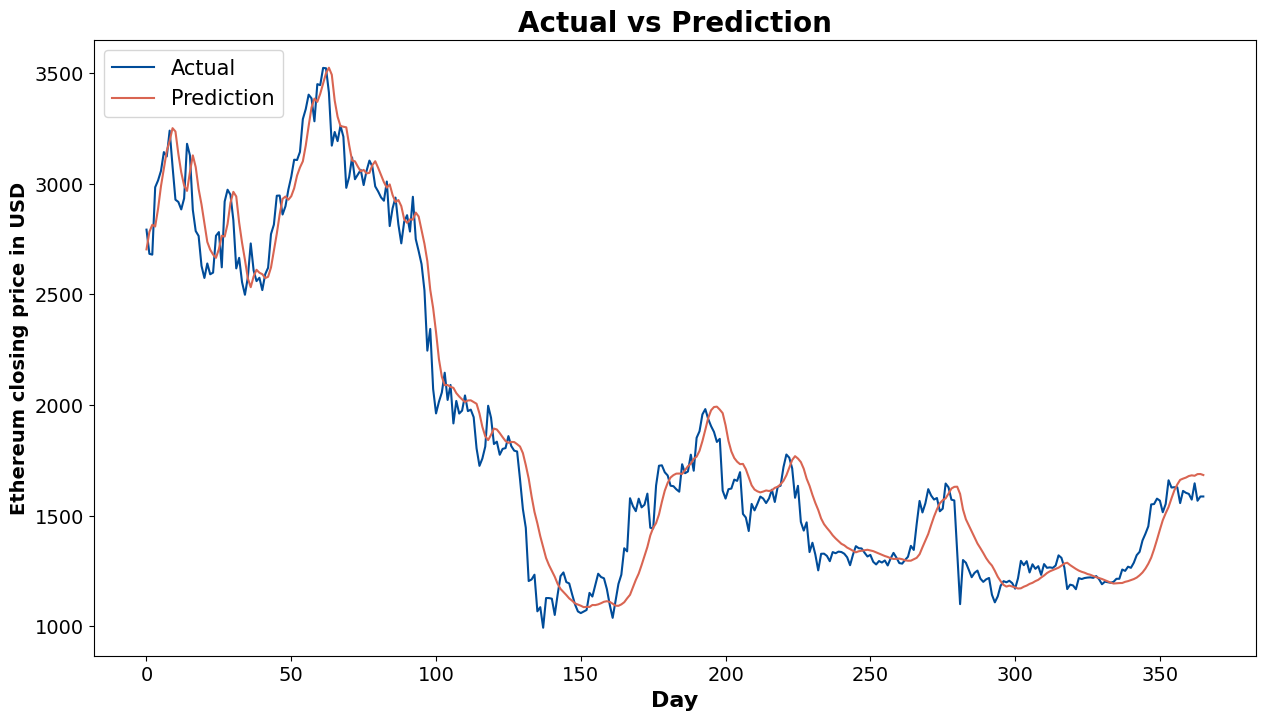

In [77]:
plot_future(prediction_bilstm, original_ytest)

In [78]:
df_plot = pd.DataFrame({ 'Actual': original_ytest.squeeze(), 'Prediction':prediction_bilstm.squeeze() })
import plotly.express as px
fig = px.line(df_plot, x=df_plot.index.values, y=df_plot.columns,
              title='custom tick labels')
fig.update_layout(title_text='Actual vs Prediction', 
                   font_size=15, font_color='black', legend_title_text='Legend')
fig.update_xaxes(title='Days')
fig.update_yaxes(title='Ethereum closing price in USD')
fig.show()

Evaluating the BiLSTM model

In [79]:
# Error metrics Computation
print('BiLSTM model')
print("MAE : % f" %(mean_absolute_error(original_ytest, prediction_bilstm)))
print("RMSE : % f" %(mean_squared_error(original_ytest, prediction_bilstm, squared=False)))
print("MAPE : % f" %(mean_absolute_percentage_error(original_ytest, prediction_bilstm)*100))
print("R2 : % f" %(r2_score(original_ytest, prediction_bilstm)))

BiLSTM model
MAE :  105.597556
RMSE :  140.907405
MAPE :  6.340200
R2 :  0.959577


In [80]:
tf.keras.backend.clear_session()